In [ ]:
import torch
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available!
Device Name: Tesla T4


--- Starting Adam optimization ---
Compiling model...
Building feed-forward neural network...
'build' took 0.056768 s

'compile' took 0.733531 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.02e-01, 8.48e-01, 5.37e-01]    [9.17e-02, 8.48e-01, 5.37e-01]    [2.19e+00]    
1000      [3.58e-04, 9.23e-06, 7.84e-06]    [3.98e-04, 9.23e-06, 7.84e-06]    [6.73e-03]    
2000      [1.52e-04, 3.84e-06, 4.05e-06]    [1.69e-04, 3.84e-06, 4.05e-06]    [4.43e-03]    
3000      [1.03e-04, 4.54e-06, 4.36e-06]    [1.04e-04, 4.54e-06, 4.36e-06]    [4.95e-03]    
4000      [5.18e-04, 3.92e-04, 2.67e-04]    [3.56e-04, 3.92e-04, 2.67e-04]    [5.08e-02]    
5000      [8.39e-05, 2.24e-05, 2.03e-05]    [9.03e-05, 2.24e-05, 2.03e-05]    [1.20e-02]    
6000      [4.74e-05, 1.96e-06, 4.60e-06]    [4.17e-05, 1.96e-06, 4.60e-06]    [3.57e-03]    
7000      [2.30e-05, 1.70e-06, 2.82e-06]    [2.35e-05, 1.70e-06, 2.82e-06]    [3.40e-03]   

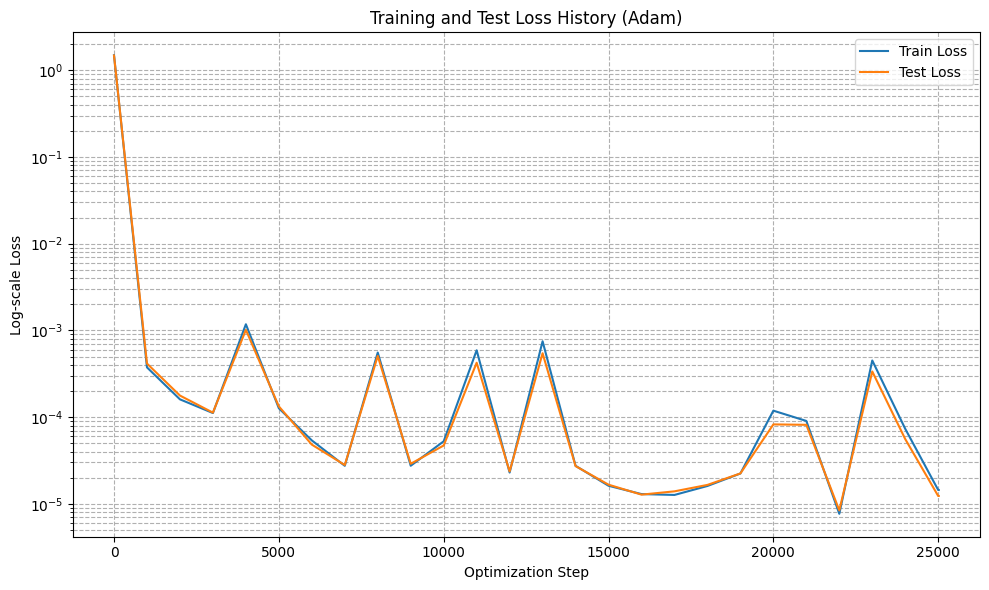


--- Generating Final Solution Plots ---
Solution comparison plot saved to annulus_solution_comparison.png


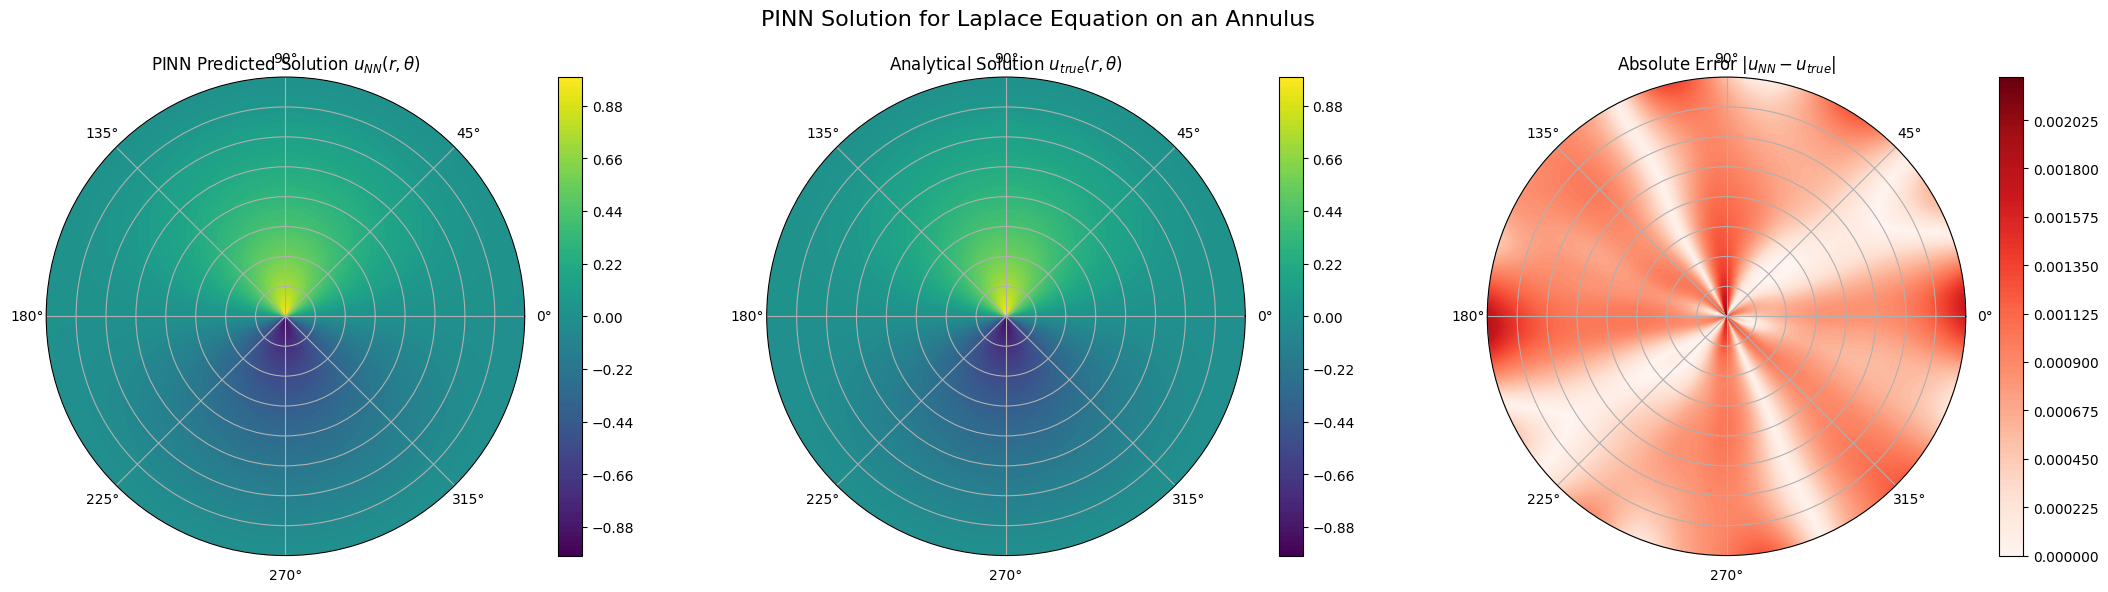


Final L2 relative error on plot points: 2.2617e-03


In [3]:
"""
Solves the Laplace equation (a special case of the Poisson equation) on an
annulus using a Physics-Informed Neural Network (PINN) with DeepXDE.

This script includes:
- Annulus geometry definition.
- Dirichlet boundary conditions: u=sin(theta) on the inner boundary (r=1) and
  u=0 on the outer boundary (r=3).
- Derivation and use of the exact analytical solution for validation.
- A two-stage training process (Adam and L-BFGS).
- Visualization of the loss history and final solution comparison, with each
  plot saved to a separate PNG file.
"""

!pip install deepxde
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# --- 1. Configuration and Setup ---

# Set the backend to PyTorch for consistency.
os.environ['DDE_BACKEND'] = 'pytorch'
# Set a random seed for reproducibility.
dde.config.set_random_seed(42)


# --- 2. Problem Definition: Geometry, PDE, and Boundary Conditions ---

# Define the annulus geometry with inner radius r1=1 and outer radius r2=3.
disk_outer = dde.geometry.Disk(center=[0, 0], radius=3)
disk_inner = dde.geometry.Disk(center=[0, 0], radius=1)
geom = dde.geometry.CSGDifference(disk_outer, disk_inner)

def pde(x, u):
    """
    Defines the residual of the Laplace equation: ∇²u = 0.
    This is a Poisson equation with a zero forcing term.
    """
    # The Laplacian is computed by summing the second partial derivatives.
    dudx2 = dde.grad.hessian(u, x, i=0, j=0)
    dudy2 = dde.grad.hessian(u, x, i=1, j=1)
    laplacian = dudx2 + dudy2
    return laplacian

def analytical_solution(x):
    """
    Computes the exact analytical solution in Cartesian coordinates.
    The solution to ∇²u = 0 in polar coordinates for the given BCs is:
    u(r, θ) = (9/(8r) - r/8) * sin(θ)
    """
    x_ = x[:, 0:1]
    y_ = x[:, 1:2]
    # Convert Cartesian (x, y) to polar (r, theta) coordinates.
    r = np.sqrt(x_**2 + y_**2)
    theta = np.arctan2(y_, x_)
    # Note: sin(theta) can also be written as y/r
    return (9 / (8 * r) - r / 8) * np.sin(theta)

# Define boundary identification functions
def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose(np.linalg.norm(x, axis=-1), 3)

def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose(np.linalg.norm(x, axis=-1), 1)

# Define boundary condition value functions
def bc_inner_func(x):
    """
    Boundary condition on the inner circle (r=1): u = sin(θ).
    """
    y_ = x[:, 1:2]
    r_ = np.sqrt(x[:, 0:1]**2 + y_**2)
    # sin(theta) = y/r
    return y_ / r_

# Create the Dirichlet Boundary Condition objects.
# Outer boundary: u = 0
bc_outer = dde.DirichletBC(geom, lambda x: 0, boundary_outer)
# Inner boundary: u = sin(theta)
bc_inner = dde.DirichletBC(geom, bc_inner_func, boundary_inner)


# --- 3. Create the Model and Data ---

# Create the PDE data object with the list of boundary conditions.
data = dde.data.PDE(
    geom,
    pde,
    [bc_outer, bc_inner],
    num_domain=3000,
    num_boundary=1000,
    solution=analytical_solution,
    num_test=1500,
)

# Define the neural network architecture.
net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot normal")

# Create the deepxde model.
model = dde.Model(data, net)


# --- 4. Train the Model ---

# Stage 1: Adam optimizer
print("--- Starting Adam optimization ---")
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
adam_losshistory, train_state = model.train(iterations=25000)

# Stage 2: L-BFGS optimizer for fine-tuning.
print("\n--- Starting L-BFGS optimization ---")
model.compile("L-BFGS")
lbfgs_losshistory, train_state = model.train()


# --- 5. Visualize Training History ---
print("\n--- Generating Loss History Plot ---")

# Extract loss data from the Adam training history
loss_train = np.sum(adam_losshistory.loss_train, axis=1)
loss_test = np.sum(adam_losshistory.loss_test, axis=1)
steps = adam_losshistory.steps

# Create and save the loss plot
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_train, label='Train Loss')
plt.plot(steps, loss_test, label='Test Loss')
plt.yscale('log')
plt.title('Training and Test Loss History (Adam)')
plt.xlabel('Optimization Step')
plt.ylabel('Log-scale Loss')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("annulus_loss_history.png")
print("Loss history plot saved to annulus_loss_history.png")
plt.show()


# --- 6. Visualize the Final Results ---
print("\n--- Generating Final Solution Plots ---")

# Generate a dense grid of points for plotting.
n_r, n_theta = 100, 200
r_vals = np.linspace(1, 3, n_r)
theta_vals = np.linspace(0, 2 * np.pi, n_theta)
r_grid, theta_grid = np.meshgrid(r_vals, theta_vals)

# Convert polar grid to Cartesian for prediction
x_grid = r_grid * np.cos(theta_grid)
y_grid = r_grid * np.sin(theta_grid)
plot_points = np.hstack((x_grid.flatten()[:, None], y_grid.flatten()[:, None]))

# Make predictions and calculate error
u_pred = model.predict(plot_points)
u_true = analytical_solution(plot_points)
error = np.abs(u_pred - u_true)

# Reshape data for plotting
u_pred_grid = u_pred.reshape(n_theta, n_r)
u_true_grid = u_true.reshape(n_theta, n_r)
error_grid = error.reshape(n_theta, n_r)

# Create a figure with three subplots using polar projection.
fig, axes = plt.subplots(1, 3, figsize=(22, 6), subplot_kw={'projection': 'polar'})
fig.suptitle('PINN Solution for Laplace Equation on an Annulus', fontsize=16)
levels = np.linspace(min(u_true.min(), u_pred.min()), max(u_true.max(), u_pred.max()), 101)

# Plot 1: PINN Predicted Solution
c1 = axes[0].contourf(theta_grid, r_grid, u_pred_grid, levels=levels, cmap='viridis')
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('PINN Predicted Solution $u_{NN}(r, \\theta)$')
axes[0].set_yticklabels([])

# Plot 2: Analytical Solution
c2 = axes[1].contourf(theta_grid, r_grid, u_true_grid, levels=levels, cmap='viridis')
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('Analytical Solution $u_{true}(r, \\theta)$')
axes[1].set_yticklabels([])

# Plot 3: Absolute Error
c3 = axes[2].contourf(theta_grid, r_grid, error_grid, levels=100, cmap='Reds')
fig.colorbar(c3, ax=axes[2])
axes[2].set_title('Absolute Error $|u_{NN} - u_{true}|$')
axes[2].set_yticklabels([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("annulus_solution_comparison.png")
print("Solution comparison plot saved to annulus_solution_comparison.png")
plt.show()

# Finally, print the L2 relative error on the test data.
final_error = dde.metrics.l2_relative_error(u_true, u_pred)
print(f"\nFinal L2 relative error on plot points: {final_error:.4e}")

